In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

%matplotlib inline
#plt.style.use('ggplot')

In [2]:
year = datetime.now().year
url_data = 'https://cdn.rawgit.com/collabmarket/data_afp/master/data/VC-MODELO.csv'
afp_name = url_data.split('-')[-1].split('.')[0]
afp = pd.read_csv(url_data, index_col=0, parse_dates=True)
afp.dropna(inplace=True)

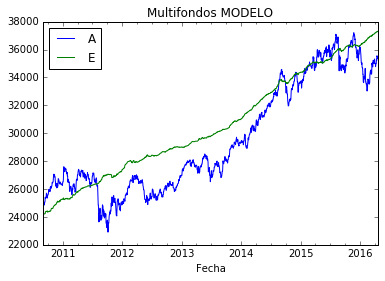

In [3]:
afp.loc[:,['A','E']].plot(title='Multifondos %s'%(afp_name))

In [4]:
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E

In [5]:
# Zero es Nivel indiferencia arbitrario
# Parametros: ['median',365] (elejimos media movil 365)
afp['zero'] = afp.delta.rolling(window=365,center=False).median()
# Supuestos:
# Zero representa valor relativo fondo A comparable con E
# fondo E refugio A es como una pseudo Inverse exchange-traded cuando hay alta volatilidad
# Cambios entre renta variable (fondo A) y renta fija (fondo E)
# Estrategia objetivo "comprar barato y vender caro"
print "Describe zero %s:"%(afp_name)
print afp.zero.describe()

Describe zero MODELO:
count    1695.000000
mean    -1273.413971
std      1044.139048
min     -2571.720000
25%     -2254.550000
50%     -1595.060000
75%      -128.680000
max       963.210000
Name: zero, dtype: float64


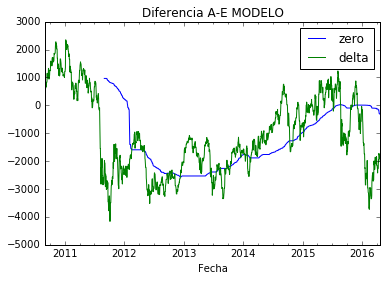

In [6]:
# Grafico de tendencia Delta diferencia entre A y E con nivel de indiferencia Zero
afp[['zero','delta']].plot(title='Diferencia A-E %s'%(afp_name))
# Observaciones:

# Se observa que hay una tendencia en que Delta converge a valor cercano a 0
# Cada vez es menos atractiva la estrategia de cambio de fondo entre A y E
# Pues variabilidad de Delta tienden a ser mas frecuentes y de menor aplitud

## Estrategias "ex post" (Basada en datos actuales en lugar de pronosticos)

# Estrategia "Evitar perdidas" (ejemplo: Felices y Forrados)
# Es muy dificil pues caidas son mas abruptas que subidas
# Consiste en mantenerse en A y refujiar en E implica aplicar "stop lost" algo muy dificil
# de implementar por la lentitud de los plazos cambio de fondo

# Estrategia propuesta "Aprovechar recuperacion"
# Dado que subida es mas lenta que caida mas acorde con lentitud de cambios de fondo 
# Consiste en mantenerse en E y despues de una gran caida entrar a A para aprovechar recuperacion
# implica aplicar un criterio arbitrario de "entrada" que define gran caida e inicio recuperacion

# Luego del periodo de recuperacion se sale de A mientras la probabilidad de recuperacion sea alta
# implica aplicar "stop gain" se debe elegir un criterio arbitrario de "salida"
# Criterios propuestos de salida:
# - Nivel de delta con probabilidad de recuraperacion acotada (tiene problema caso "recuperacion aparente")
# - Una rentabilidad objetivo proporcional a la reciente caida

# Dado que variaciones de delta tienden a ser mas frecuentes y de menor aplitud, esta estrategia
# tambien es cada vez mas dificil de implementar por la lentitud de cambios de fondo

# Estrategia dual "Evitar perdidas y Aprovechar recuperaciones"
# Entre el 2004 y el 2012 esta estrategia pudo aprovecharse ya que variacion tendencia de delta
# fue en ciclos grandes de gran amplitud
# A partir del 2012 variacion tendencia delta es de ciclos cortos y baja amplitud, por lo que
# solo la estrategia de aprovechar recuperacion es atractiva
# 

## Estrategias "ex ante" (Basada en pronósticos en lugar de datos actuales)

# En teoria se podria hacer ambas estrategias evitar caidas del A y aprovechar recuperaciones del A, 
# Si se pudiera "predecir" cambios de tendencia en los mercados en el mediano plazo seria factible, pero
# Nadie a demostrato un metodo consistente para lograr eso

In [7]:
# Valor de A es relativamente mas alto que E  [delta > zero]
# Valor de A es relativamente mas bajo que E [delta < zero]

afp['valorA'] = pd.np.where(afp['delta'] < afp['zero'], 'bajo', 'alto')
afp['bajo'] = afp.delta[afp.delta<afp.zero]
afp['alto'] = afp.delta[afp.delta>afp.zero]

# Después de una caida de A la probabilidad de ganacia E->A es alta (recuperacion)
# pues se supone que renta variable en promedio genera mas valor que renta fija
# pero para eso es necesario detectar minimo local de valor de A

# Warning: "Probabilidad de ganancia E->A" != 1-"Probabilidad de perdida de A"
# Antes de grandes caidas, hay mucha volatilidad con recuperaciones "aparentes"
# que preceden grandes caidas, por eso es necesario ademas tener datos de riesgo sistemico

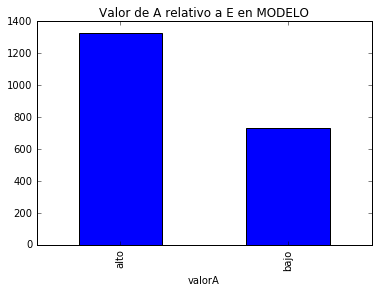

In [8]:
# Cuenta dias en que valor de A es alto y bajo con respecto a E
afp.groupby('valorA').count()['delta'].plot(kind='bar', title='Valor de A relativo a E en %s'%(afp_name))
# Del grafico se puede obserbar que eventos con probabilidad ganancia E->A son menos frecuentes
# Posible estrategias:
# Mantener siempre en fondo E y aprovechar eventos puntuales de recuperacion valores minimos de A con respecto a E.

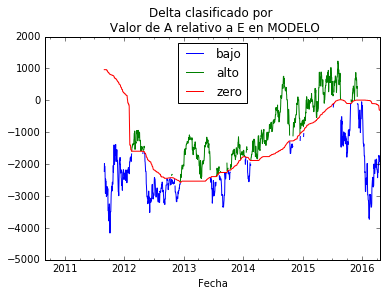

In [9]:
afp.loc[:,['bajo','alto','zero']].plot(title='Delta clasificado por \n Valor de A relativo a E en %s'%(afp_name))

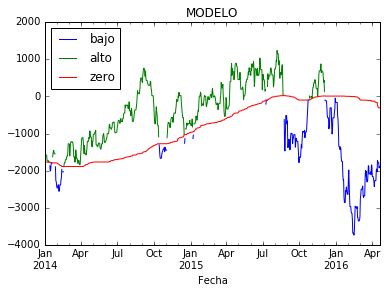

In [10]:
# Zoom desde dos años al presente
init = str(year - 2)
afp.loc[init:,['bajo','alto','zero']].plot(title='%s'%(afp_name))

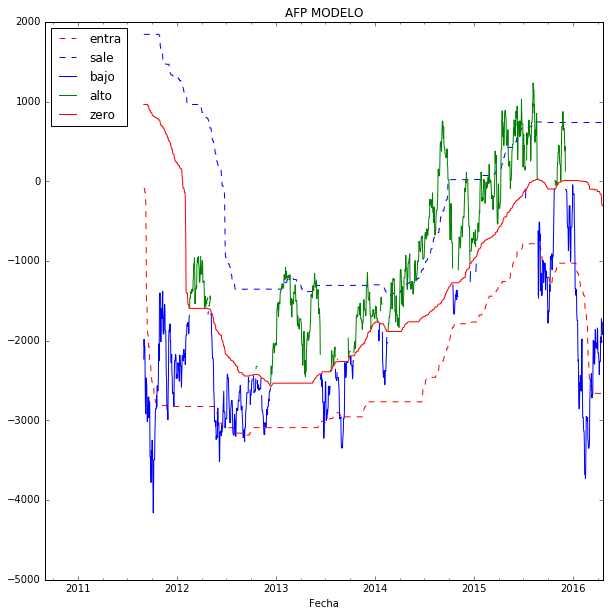

In [11]:
## Estrategia "Aprovechar recuperacion" y "Evitar perdidas" con stop gain
# Criterios de Entrada
# Parametros: ['quantile',0.1,365] (elejimos cuantil 10% ventana 365)
# min < delta =~ entra 
# Criterios de Salida
# Parametros: ['quantile',0.9,365] (elejimos cuantil 90% ventana 365)

afp['rate'] = afp.delta.pct_change(15)
afp['entra'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.1)
afp['sale'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.9)
ax = afp.loc[:,['entra','sale']].plot(title='AFP %s'%(afp_name), style=['--r','--b'])
afp.loc[:,['bajo','alto','zero']].plot(title='AFP %s'%(afp_name), figsize=(10,10), style=['b','g','r'], ax=ax)

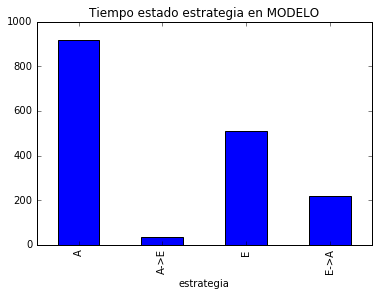

In [12]:
afp['estrategia'] = None
# Definicion reglas de la estrategia
afp.loc[afp.delta < afp.entra,'estrategia'] = 'E'
afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
afp.loc[(afp.delta < afp.zero) & (afp.delta > afp.entra) & (afp.rate > 0),'estrategia'] = 'E->A'
afp.loc[(afp.delta < afp.zero) & (afp.delta > afp.entra) & (afp.rate < 0),'estrategia'] = 'E'
afp.loc[(afp.delta > afp.zero) & (afp.delta < afp.sale),'estrategia'] = 'A'
afp.loc[(afp.delta > afp.sale) & (afp.rate > 1),'estrategia'] = 'A->E'
afp.groupby('estrategia').count()['zero'].plot(kind='bar', title='Tiempo estado estrategia en %s'%(afp_name))

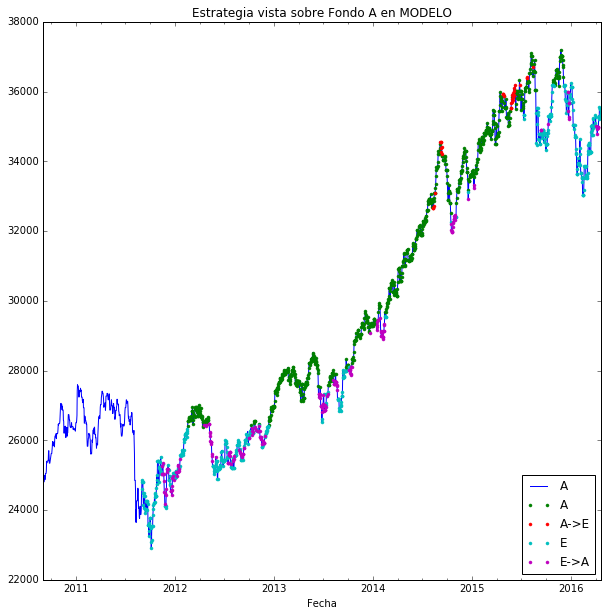

In [13]:
# Se observa que esta estrategia mas conservadora momento de cambio de A -> E 
ax = afp.A.plot()
ax = afp.groupby('estrategia').A.plot(style='.', figsize=(10,10), title='Estrategia vista sobre Fondo A en %s'%(afp_name),ax=ax)
plt.legend(loc=4)

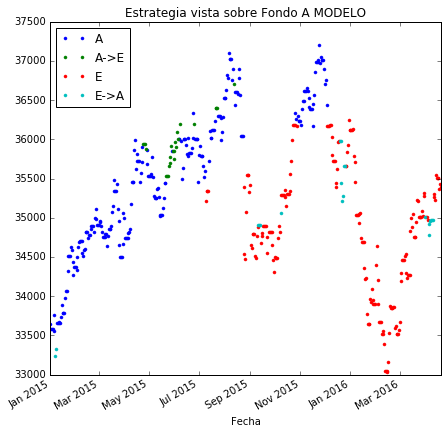

In [14]:
# Se observa que esta estrategia mas conservadora momento de cambio de A -> E 
init = str(year - 1)
fig, ax = plt.subplots()
afp[init:].groupby('estrategia').A.plot(style='.', figsize=(7,7), title='Estrategia vista sobre Fondo A %s'%(afp_name), ax=ax)
ax.legend(loc=2)
fig.savefig('result/A-E_%s.png'%(afp_name))

In [15]:
# Ultimas 15 dias de estrategia
afp.iloc[-15:][['A','E','estrategia']]

,A,E,estrategia
Fecha,,,
2016-04-06,34775.04,37200.06,E->A
2016-04-07,34960.04,37233.11,E->A
2016-04-08,34971.52,37234.19,E->A
2016-04-09,34971.52,37234.19,E->A
2016-04-10,34971.52,37234.19,E->A
2016-04-11,35262.82,37243.81,E
2016-04-12,35306.16,37259.34,E
2016-04-13,35224.49,37250.15,E
2016-04-14,35549.81,37274.87,E


In [16]:
#%qtconsole